# Simple Neural Network

In [1]:
import numpy as np
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

# Dataset

In [2]:
class DividedPlane(torch.utils.data.Dataset):
    def __init__(self, n=100, noise=0.1, seed=None):
        a = torch.tensor([-0.4, 0.5, 0.15]) #torch.rand((3,))
        def myfunc(x):
            y = a[0]*x[:,0] + a[1]*x[:,1] + a[2]
            return y
        self.x = torch.rand((n,2))*2. - 1.
        y = myfunc(self.x) + noise*torch.normal( torch.zeros((len(self.x))) )
        self.y = (y>0.).type(torch.float)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
    def inputs(self):
        return self.x
    
    def targets(self):
        return self.y.reshape( (len(self.y),1) )
    
    def plot(self, labels=None, *args, **kwargs): 
        X = self.inputs()
        if labels is None:
            labels = self.targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        if len(labels[0])>1:
            # one-hot labels
            cidx = torch.argmax(labels, axis=1)
        else:
            # binary labels
            cidx = (labels>0.5).type(torch.int)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X[:,0].detach(), X[:,1].detach(), color=colours, marker='.')


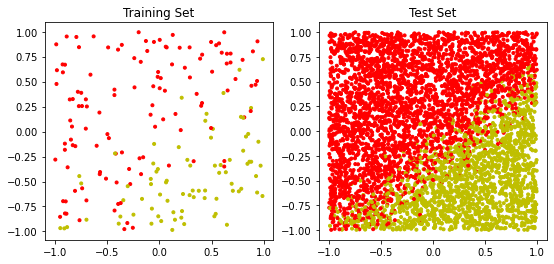

In [3]:
train = DividedPlane(n=200, noise=0.2, seed=165)
test = DividedPlane(n=5000)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); train.plot(); plt.title(f'Training Set');
plt.subplot(1,2,2); test.plot(); plt.title(f'Test Set');

# `RobustNetwork` class

In [4]:
class RobustNetwork(torch.nn.Module):
    def __init__(self, nodes=[2, 100, 1]):
        super().__init__()
        self.lyrs = torch.nn.ModuleList()
        for k,n in enumerate(nodes[:-2]):
            self.lyrs.append(torch.nn.Linear(n, nodes[k+1]))
            self.lyrs.append(torch.nn.ReLU())
        self.lyrs.append(torch.nn.Linear(nodes[-2], nodes[-1]))
        self.lyrs.append(torch.nn.Sigmoid())
        self.loss_fcn = torch.nn.BCELoss(reduction='mean')
        self.losses = []
    
    def forward(self, x):
        y = x
        for lyr in self.lyrs:
            y = lyr(y)
        return y

    # A helper function can be used to compute the Frob norm
    def weight_penalty(self):
        penalty = 0.
        for p in self.parameters():
            penalty += torch.sum(p**2)
        return penalty
    
    def learn(self, x, t, epochs=100, lr=0.1, weight_decay=0., plot=True):
        for epoch in range(epochs):
            y = self(x)
            
            # Add Frobenius norm of weights to the loss
            loss = self.loss_fcn(y.squeeze(), t.squeeze()) + 0.5*weight_decay*self.weight_penalty()                
            
            self.losses.append(loss.item())
            self.zero_grad()
            loss.backward()
            with torch.no_grad():
                for p in self.parameters():
                    p -= lr*p.grad
        if plot:
            plt.plot(np.array(self.losses))
            plt.yscale('log'); plt.xlabel('Epochs'); plt.ylabel('Log Loss');
            print(f'Final loss = {loss}')


# Train

In [5]:
#===== Parameters set 1 =====
nodes = [2, 250, 200, 1]
lrate = 0.5
n_epochs = 1000
wd = 0.0

In [6]:
#===== Parameters set 2 =====
nodes = [2, 30, 20, 1]
lrate = 0.5
n_epochs = 1000
wd = 0.005

In [7]:
net = RobustNetwork(nodes=nodes)

Final loss = 0.34655290842056274


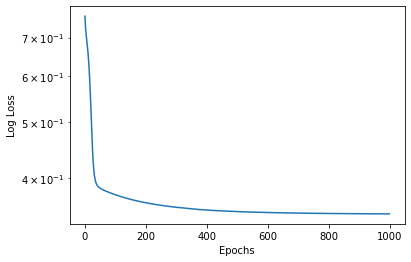

In [8]:
# Learn
net.learn(train.inputs(), train.targets(), epochs=n_epochs, lr=lrate, weight_decay=wd, plot=True)

# Test

In [9]:
y = net(test.inputs())
test_loss = net.loss_fcn(y, test.targets())
print(f'Test loss = {test_loss}')

Test loss = 0.21205075085163116


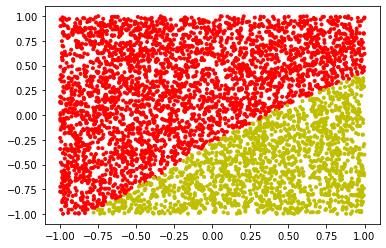

In [10]:
test.plot(labels=y);